<b><h1><center>MovieLens Reccomdation 

202211014- Nikunj Rathod

202211019- Jainisha Choksi

202211036- Arjun Vankani

202211055- Prathamesh Potdar

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import scipy
import random
from surprise import AlgoBase, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate,train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from surprise import KNNWithZScore
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.read_csv('/content/ratings.csv')
df

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [ ]:
df.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
movie_data = pd.read_csv("/content/movies.csv")
movie_data

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9120,162672,Mohenjo Daro (2016),Adventure|Drama|Romance
9121,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
9122,163949,The Beatles: Eight Days a Week - The Touring Years (2016),Documentary
9123,164977,The Gay Desperado (1936),Comedy


In [ ]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9125 non-null   int64 
 1   title    9125 non-null   object
 2   genres   9125 non-null   object
dtypes: int64(1), object(2)
memory usage: 214.0+ KB


In [ ]:
no_genre_listed = "(no genres listed)"
movie_data["genres"] = movie_data["genres"].apply(lambda genres: [ genre for genre in genres.split('|') if genre != no_genre_listed ])

In [ ]:
movie_data =  movie_data.dropna()
movie_data.shape

(9125, 3)

In [ ]:
genres_merged = movie_data["genres"].apply(lambda genres: " ".join(genres))
genres_vectorizer = CountVectorizer(token_pattern="(?u)\\b[\\w-]+\\b")
genres_count_matrix = genres_vectorizer.fit_transform(genres_merged.tolist())

In [ ]:
print("Total genres of movies : " + str(len(genres_vectorizer.vocabulary_)))

Total genres of movies : 19


In [ ]:
user_ids = df["userId"].unique().tolist()

In [ ]:
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

num_users = len(user2user_encoded)
print("Number of Users : " +str(num_users))

Number of Users : 671


In [ ]:
df["user"] = df["userId"].map(user2user_encoded)
df['user']

19090    127
99678    664
18455    119
35755    256
66536    467
        ... 
6265      32
54886    393
76820    531
860       11
15795    101
Name: user, Length: 100004, dtype: int64

In [ ]:
movie_ids = df["movieId"].unique().tolist()

movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

num_movies = len(movie2movie_encoded)
print("Number of movies : " +str(num_movies))

Number of movies : 7072


In [ ]:
df["movie"] = df["movieId"].map(movie2movie_encoded)
df['movie']

19090     165
99678    9064
18455    2763
35755    2190
66536    1333
         ... 
6265     1098
54886      64
76820    2199
860       346
15795      17
Name: movie, Length: 100004, dtype: int64

In [ ]:
df['rating'] = df['rating'].values.astype(np.float32)
df['rating']

19090    5.0
99678    1.0
18455    3.0
35755    4.0
66536    4.0
        ... 
6265     5.0
54886    3.0
76820    3.5
860      4.0
15795    3.0
Name: rating, Length: 100004, dtype: float32

In [ ]:
min_rating = min(df["rating"])
print("Minimum rating: "+str(min_rating))

Minimum rating: 0.5


In [ ]:
max_rating = max(df["rating"])
print("Maximum rating: "+str(max_rating))

Maximum rating: 5.0


In [ ]:
df = df.sample(frac=.5, random_state=42)
df

,userId,movieId,rating,timestamp,user,movie
75296,522,53322,3.5,1391353596,521,1522
86416,577,7569,5.0,1111476697,576,1402
68327,475,5478,2.0,1447327895,474,1274
4884,26,31410,2.0,1352838206,25,2055
26048,190,2622,4.0,975694759,189,3114
...,...,...,...,...,...,...
2397,15,87520,4.5,1316396021,14,1684
15197,99,2006,3.0,947519629,98,876
64429,461,2108,2.0,1091959304,460,535
6510,35,1188,0.5,1174450079,34,2289


In [ ]:
x = df[["user", "movie"]].values
x

array([[ 127,  165],
       [ 664, 9064],
       [ 119, 2763],
       ...,
       [ 531, 2199],
       [  11,  346],
       [ 101,   17]])

In [ ]:
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y

array([1.        , 0.11111111, 0.55555556, ..., 0.66666667, 0.77777778,
       0.55555556])

In [ ]:
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = ( x[:train_indices], x[train_indices:], y[:train_indices],  y[train_indices:],)

In [ ]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
       
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)
    


In [ ]:
model = RecommenderNet(num_users, num_movies, 50)
model.compile(  loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001))

In [ ]:
history = model.fit( x=x_train,  y=y_train,batch_size=64, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
1251/1251 [==============================] - 12s 9ms/step - loss: 0.6336 - val_loss: 0.6152
Epoch 2/50
1251/1251 [==============================] - 11s 9ms/step - loss: 0.6078 - val_loss: 0.6130
Epoch 3/50
1251/1251 [==============================] - 11s 8ms/step - loss: 0.6026 - val_loss: 0.6076
Epoch 4/50
1251/1251 [==============================] - 11s 9ms/step - loss: 0.6017 - val_loss: 0.6089
Epoch 5/50
1251/1251 [==============================] - 11s 9ms/step - loss: 0.6005 - val_loss: 0.6077
Epoch 6/50
1251/1251 [==============================] - 11s 9ms/step - loss: 0.6012 - val_loss: 0.6048
Epoch 7/50
1251/1251 [==============================] - 10s 8ms/step - loss: 0.6009 - val_loss: 0.6043
Epoch 8/50
1251/1251 [==============================] - 11s 9ms/step - loss: 0.5997 - val_loss: 0.6038
Epoch 9/50
1251/1251 [==============================] - 11s 9ms/step - loss: 0.5994 - val_loss: 0.6035
Epoch 10/50
1251/1251 [==============================] - 12s 9ms/step - l

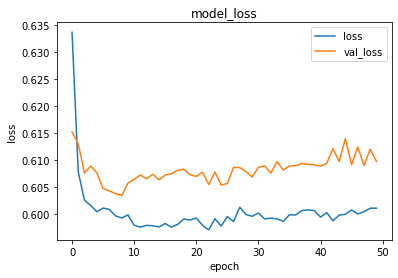

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [ ]:
movie_df = pd.read_csv('/content/movies.csv')

user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[~movie_df['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']

movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_encoder = user2user_encoded.get(user_id)

user_movie_array = np.hstack([[user_encoder]] * len(movies_not_watched), movies_not_watched))

ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_movie_ids = [ movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

281/281 [==============================] - 0s 2ms/step


In [ ]:
print("Movies with high ratings from user")
top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(5).movieId.values)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]

for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

Movies with high ratings from user
Forget Paris (1995) : Comedy|Romance
Outbreak (1995) : Action|Drama|Sci-Fi|Thriller
Game, The (1997) : Drama|Mystery|Thriller
Charlotte's Web (1973) : Animation|Children
Beautiful Mind, A (2001) : Drama|Romance


In [ ]:
print("Top 5 movie recommendations")
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Top 10 movie recommendations
Anne Frank Remembered (1995) : Documentary
Face in the Crowd, A (1957) : Drama
Step Into Liquid (2002) : Documentary
Ikiru (1952) : Drama
Paperman (2012) : Animation|Comedy|Romance
